In [2]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from white_box.data import chunk_and_tokenize, silence_datasets_messages
import torch as th

def load_stuff(name, device = 'cuda:0'):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = Dataset.from_json("/mnt/ssd-1/nora/val.jsonl")
    assert isinstance(dataset, Dataset)
    silence_datasets_messages()

    dataset = chunk_and_tokenize(dataset, tokenizer)
    return model, tokenizer, dataset

gpt2, gpt2_tokenizer, gpt2_data = load_stuff("gpt2-large")

Using custom data configuration default-0fe0deb72092fd99
Found cached dataset json (/mnt/ssd-1/nora/huggingface/datasets/json/default-0fe0deb72092fd99/0.0.0)


In [3]:
from white_box.nn import Decoder, TunedLens

gpt2_decoder = Decoder(gpt2)
gpt2_lens = TunedLens.load("/mnt/ssd-1/nora/real-lenses/gpt2/large/").cuda()

In [4]:
def kl(logit_p, logit_q):
    log_p = logit_p.log_softmax(-1)
    log_q = logit_q.log_softmax(-1)

    return th.sum(log_p.exp() * (log_p - log_q), -1)

In [5]:
def swap_topk(logits: th.Tensor, k: int = 2):
    """Reverse the order of the top-k logits."""
    top_logits, top_indices = logits.topk(k)

    swapped = logits.clone()
    swapped[..., top_indices] = top_logits.flip([-1])
    return swapped


In [6]:
lenses = gpt2_lens.layer_adapters

In [7]:
from tqdm.auto import tqdm
from white_box import layer_intervention
from white_box.utils import pytree_map

L = gpt2.config.num_hidden_layers
S = 20

with th.autocast('cuda'), th.no_grad():
    # First do a clean forward pass on all the data. We save the
    # logits, as well as the keys and values to speed up inference
    # when we do interventions. 
    inputs = gpt2_data[:10]['input_ids'].cuda()
    outputs = gpt2(inputs, output_hidden_states=True, use_cache=True)

    clean_logits = [
        gpt2_decoder(h)
        for h in outputs.hidden_states[1:-1]
    ]
    clean_kv = outputs.past_key_values
    final_logits = outputs.logits

    baseline_kls = th.zeros(S, L - 1, device='cuda')
    causal_effects_ll = th.zeros(S, L - 1, device='cuda')
    causal_effects_tl = th.zeros(S, L - 1, device='cuda')

    for token_idx in tqdm(range(1, S)):
        kv_truncated = pytree_map(lambda x: x[..., :token_idx, :], clean_kv)

        for i, clean in enumerate(clean_logits):
            target = swap_topk(clean[:, token_idx])
            baseline_kl = kl(target, final_logits[:, token_idx]).mean()

            def logit_lens_intervene(x):
                x_prime = gpt2_decoder.invert(target, h0=x)
                scale = x.norm(dim=-1) / x_prime.norm(dim=-1)
                return x_prime * scale.unsqueeze(-1)

            def tuned_lens_intervene(x):
                x_prime = gpt2_decoder.invert(target, h0=x, lens=lenses[i])
                scale = x.norm(dim=-1) / x_prime.norm(dim=-1)
                return x_prime * scale.unsqueeze(-1)

            with layer_intervention(gpt2, [i], logit_lens_intervene):
                ll_logits = gpt2(inputs[:, token_idx, None], past_key_values=kv_truncated).logits

            with layer_intervention(gpt2, [i], tuned_lens_intervene):
                tuned_logits = gpt2(inputs[:, token_idx, None], past_key_values=kv_truncated).logits

            effect_ll = baseline_kl - kl(target, ll_logits).mean()
            effect_tl = baseline_kl - kl(target, tuned_logits).mean()
            baseline_kls[token_idx, i] = baseline_kl
            causal_effects_ll[token_idx, i] = effect_ll
            causal_effects_tl[token_idx, i] = effect_tl

  0%|          | 0/19 [00:00<?, ?it/s]

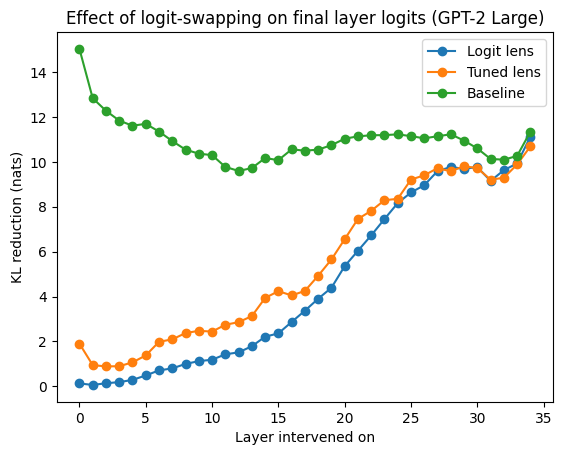

In [8]:
import matplotlib.pyplot as plt


plt.plot(
    causal_effects_ll.mean(0).cpu(),
    label="Logit lens", marker='o'
)
plt.plot(
    causal_effects_tl.mean(0).cpu(),
    label="Tuned lens", marker='o'
)
plt.plot(
    baseline_kls.mean(0).cpu(),
    label="Baseline", marker='o'
)
plt.title("Effect of logit-swapping on final layer logits (GPT-2 Large)")
plt.xlabel("Layer intervened on")
plt.ylabel("KL reduction (nats)")
plt.legend()